In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DicomCoarseDataset3D, TransformDataset

In [2]:
scenario = 1
data_augmentation = False

In [3]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
image_size = 80 #best yet 80 with 87%
classes = ["nodule", "non-nodule"]
train_ratio = 0.6

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

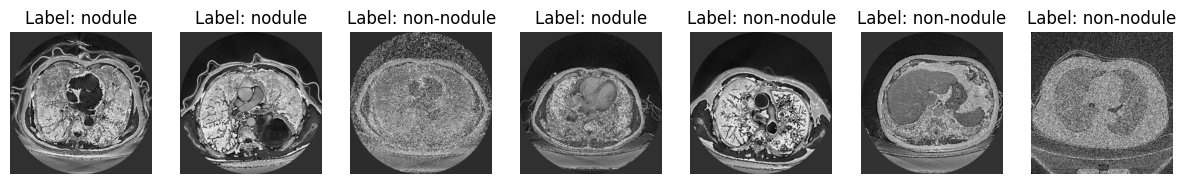

In [4]:
dataset = DicomCoarseDataset3D(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes, scenario=1)
# dataset = DicomCoarseDataset3D(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=scenario)
dataset.visualize_volumes(num_volumes=7)

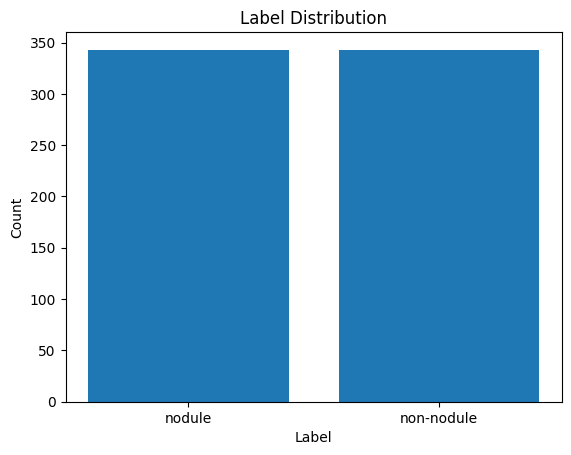

In [5]:
dataset.display_label_distribution()

In [6]:
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 411 --- Validation size: 137 --- Test size: 138


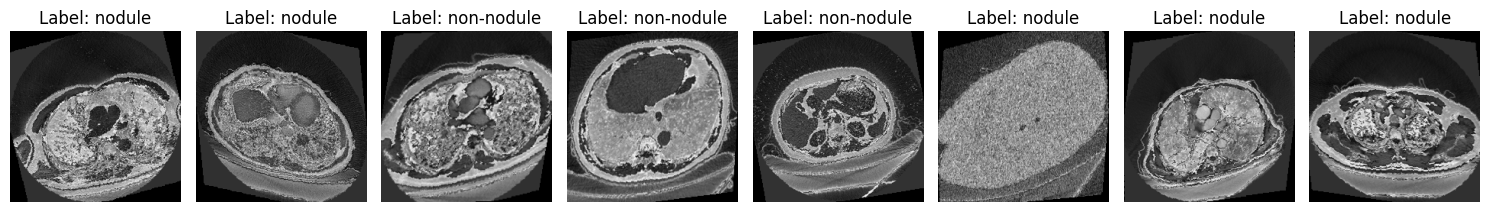

In [7]:
from utils import display_data_loader_batch_3d
display_model = TransferLearningModel(classes, "3dcnn", data_augmentation=True, fine=False, scenario=1)
display_model.train_transforms, display_model.test_transforms = display_model.get_transforms()
train_indices, val_indices, test_indices = random_split(dataset, [train_size, val_size, test_size])
train_dataset = TransformDataset(torch.utils.data.Subset(dataset, train_indices.indices), transform=display_model.train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
display_data_loader_batch_3d(train_loader, classes)

In [8]:
print("Processing model: 3D-CNN")
model = TransferLearningModel(classes, "3dcnn", data_augmentation=data_augmentation, fine=False, scenario=scenario)
# Ensure transforms are correctly applied based on model requirements
model.train_transforms, model.test_transforms = model.get_transforms()

# Create independent datasets for training, validation, and testing
train_indices, val_indices, test_indices = random_split(dataset, [train_size, val_size, test_size])

train_dataset = TransformDataset(torch.utils.data.Subset(dataset, train_indices.indices), transform=model.train_transforms)
val_dataset = TransformDataset(torch.utils.data.Subset(dataset, val_indices.indices), transform=model.test_transforms)
test_dataset = TransformDataset(torch.utils.data.Subset(dataset, test_indices.indices), transform=model.test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize early stopping
early_stopping = EarlyStopping(patience=10)

# Train the current model
model.train(train_loader, val_loader, early_stopping, epochs=50)

Processing model: 3D-CNN
Epoch 1/50 ----- Loss: 0.5607, Accuracy: 81.27% ----- Validation Loss: 11.6246, Validation Accuracy: 53.28%
Epoch 2/50 ----- Loss: 0.3590, Accuracy: 85.16% ----- Validation Loss: 2.3805, Validation Accuracy: 56.93%
Epoch 3/50 ----- Loss: 0.3273, Accuracy: 86.13% ----- Validation Loss: 0.5278, Validation Accuracy: 77.37%
Epoch 4/50 ----- Loss: 0.2962, Accuracy: 87.83% ----- Validation Loss: 0.3761, Validation Accuracy: 82.48%
Epoch 5/50 ----- Loss: 0.2527, Accuracy: 91.24% ----- Validation Loss: 0.4302, Validation Accuracy: 77.37%
Epoch 6/50 ----- Loss: 0.2015, Accuracy: 94.16% ----- Validation Loss: 0.4600, Validation Accuracy: 76.64%
Epoch 7/50 ----- Loss: 0.1408, Accuracy: 96.59% ----- Validation Loss: 0.3992, Validation Accuracy: 83.21%
Epoch 8/50 ----- Loss: 0.0972, Accuracy: 98.30% ----- Validation Loss: 0.3530, Validation Accuracy: 84.67%
Epoch 9/50 ----- Loss: 0.0911, Accuracy: 98.05% ----- Validation Loss: 0.3145, Validation Accuracy: 85.40%
Epoch 10/50

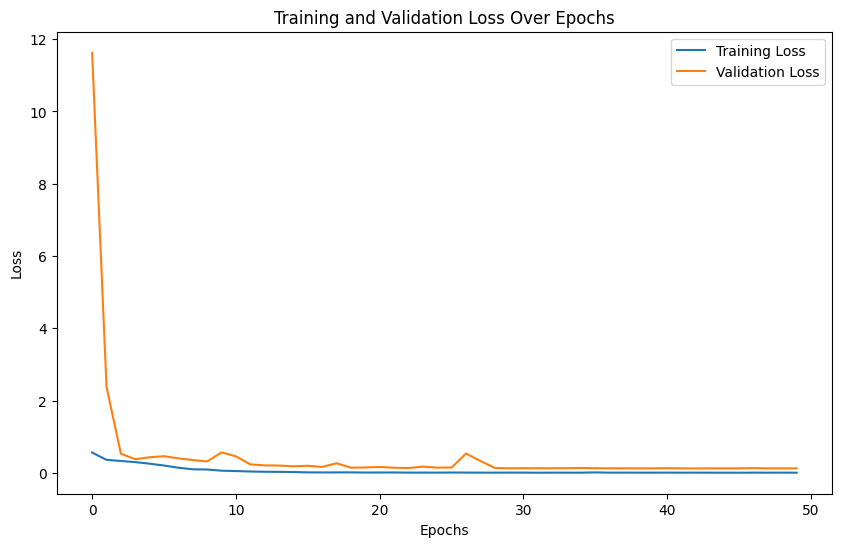

In [9]:
model.plot_loss()

0.120835560081649
Evaluation Accuracy on unseen data: 95.65217391304348


<Figure size 1000x800 with 0 Axes>

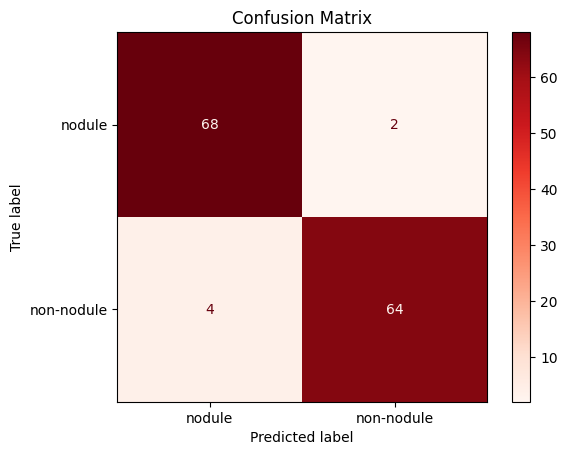

In [10]:
checkpoint = torch.load(f"weights/coarse/scenario{scenario}/{model.model_name}.pt", weights_only=False)
model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
model.evaluate(test_loader)